# 前提

## インポート

In [862]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from keras.utils import np_utils 
import tqdm

In [863]:
pd.set_option('display.max_rows',10)
pd.set_option('display.max_columns', 10)

## モデル

### 普通のLFA

In [690]:
class MatrixFactorization():
    def __init__(self, R, k, steps=200, alpha=0.01, lamda=0.001,threshold=0.001):
        self.R = R
        self.m = R.shape[0]#Rの列数
        self.n = R.shape[1]#Rの行数
        self.X=np.arange(0,self.m)
        self.Y=np.arange(0,self.n)
        self.k = k #潜在因子分析の次元
        # initializa U and V
        self.U = np.random.rand(self.m, self.k)#0.0から1の範囲でm×k行列の乱数を発生させる
        self.V = np.random.rand(self.k, self.n)#0.0から1の範囲でk×n行列の乱数を発生させる
        self.alpha = alpha #学習率
        self.lamda = lamda #正則化項の係数
        self.threshold = threshold #誤差の閾値
        self.steps = steps #シャッフルする回数
        
    def shuffle_in_unison_scary(self, a, b):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)

    def fit(self):
        for step in tqdm.tqdm(range(self.steps)):
            error = 0
            self.shuffle_in_unison_scary(self.X,self.Y)
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i,j] #r_ij=R[i,j]とする
                    if r_ij != 0: #Rの要素が0以外の値をとる場合更新する
                        err_ij = r_ij - np.dot(self.U[i,:], self.V[:,j]) #誤差err_ijはr_ijからUのi-1行目とVのj-1列目をかけあわせたものを引いた値
                        for q in range(self.k):#潜在因子分析の次元数であるk回以下を繰り返す
                            delta_u = self.alpha * (err_ij * self.V[q, j] - self.lamda * self.U[i, q])
                            delta_v = self.alpha * (err_ij * self.U[i, q] - self.lamda * self.V[q, j])
                            self.U[i, q] += delta_u
                            self.V[q, j] += delta_v
                            

            R_hat = np.dot(self.U, self.V) #UとVを掛け合わせたものがR_hatになる
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i, j]
                    r_hat_ij = R_hat[i, j]
                    if r_ij != 0:
                        error += pow(r_ij - r_hat_ij,2)/2
            error += (self.lamda * np.power(self.U,2).sum()) / 2
            error += (self.lamda * np.power(self.V,2).sum()) / 2

            if error < self.threshold:
                break
        return self.U, self.V

### 提案手法１(重みを変えない)

#### どちらにもクラスター

In [761]:
class MatrixFactorization_1():
    def __init__(self,R,C,D,U,V,k,steps=200, alpha=0.001,beta=1.0,ganma=1.0,lamda=0.01,threshold=0.001):
        self.R = R
        self.C = C
        self.D = D
        
        self.m = R.shape[0]#Rの行数
        self.n = R.shape[1]#Rの列数
        self.l = C.shape[1]#Cの列数
        self.o = D.shape[0]#Dの行数
        
        self.X=np.arange(0,self.m)
        self.Y=np.arange(0,self.n)
        self.Z=np.arange(0,self.l)
        self.A=np.arange(0,self.o)
        self.k = k #潜在因子分析の次元
        
        self.U = U
        self.V = V #転置した状態のものを入れる
        self.S = np.random.rand(self.k, self.l)#0.0から1の範囲でk×l行列の乱数を発生させる
        self.T = np.random.rand(self.o, self.k)#0.0から1の範囲でo×k行列の乱数を発生
        
        self.alpha = alpha #学習率
        self.beta = beta #CとPSの誤差の係数
        self.ganma = ganma #DとTVの誤差の係数
        self.lamda = lamda #正則化項の係数
        self.threshold = threshold #誤差の閾値
        self.steps = steps #シャッフルする回数
        
    def shuffle_in_unison_scary(self, a, b):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)
        np.random.set_state(rng_state)
        np.random.shuffle(c)
        np.random.set_state(rng_state)
        np.random.shuffle(d)

    def fit(self):
        for step in tqdm.tqdm(range(self.steps)):
            error = 0
            self.shuffle_in_unison_scary(self.X,self.Y,self.Z,self.A)
            for i in self.X:
                #beta_i=round(self.beta*(1/self.user_clust_std[self.label_U[i]]),3)
                for j in self.Y:
                    #ganma_j=round(self.ganma*(1/self.service_clust_std[self.label_V[j]]),3)
                    r_ij = self.R[i,j] #r_ij=R[i,j]とする
                    for l in self.Z:
                        c_il = self.C[i,l] #c_il=C[i,l]とする
                        err_c_il=c_il-np.dot(self.U[i,:],self.S[:,l])#cの誤差
                        for k in self.A:
                            d_kj = self.D[k,j]
                            err_d_kj = d_kj-np.dot(self.T[k,:],self.V[:,j])
                            if r_ij != 0: #Rの要素が0以外の値をとる場合更新する
                                err_r_ij = r_ij - np.dot(self.U[i,:], self.V[:,j]) #誤差err_r_ijはr_ijからUのi行目とVのj列目をかけあわせたものを引いた値
                                for q in range(self.k):#潜在因子分析の次元数であるk回以下を繰り返す
                                    delta_u = self.alpha * (err_r_ij * self.V[q, j] + self.beta * err_c_il * self.S[q,l]- self.lamda * self.U[i, q])
                                    delta_v = self.alpha * (err_r_ij * self.U[i, q] +self.ganma * err_d_kj * self.T[k,q]- self.lamda * self.V[q, j])
                                    delta_s = self.alpha * (self.beta * err_c_il * self.U[i, q] - self.lamda * self.S[q,l])
                                    delta_t = self.alpha * (self.ganma * err_d_kj * self.V[q,j] - self.lamda * self.T[k,q])
                                    self.U[i, q] += delta_u
                                    self.V[q, j] += delta_v
                                    self.S[q, l] += delta_s
                                    self.T[k, q] += delta_t

            R_hat = np.dot(self.U, self.V) #UとVを掛け合わせたものがR_hatになる
            C_hat = np.dot(self.U, self.S)
            D_hat = np.dot(self.T, self.V)
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i, j]
                    r_hat_ij = R_hat[i, j]
                    if r_ij != 0:
                        error += pow(r_ij - r_hat_ij,2)/2
            for i in self.X:
                #beta_i=round(self.beta*(1/self.user_clust_std[self.label_U[i]]),3)
                for l in self.Z:
                    c_il = self.C[i,l]
                    c_hat_il = C_hat[i,l]
                    error += self.beta*pow(c_il-c_hat_il,2)/2
            for j in self.Y:
                #ganma_j=round(self.ganma*(1/self.service_clust_std[self.label_V[j]]),3)
                for k in self.A:
                    d_kj = self.D[k,j]
                    d_hat_kj = D_hat[k,j]
                    error += self.ganma*pow(d_kj-d_hat_kj,2)/2
                    
            error += (self.lamda * np.power(self.U,2).sum()) / 2
            error += (self.lamda * np.power(self.V,2).sum()) / 2
            error += (self.lamda * np.power(self.S,2).sum()) / 2
            error += (self.lamda * np.power(self.T,2).sum()) / 2

            if error < self.threshold:
                break
        return self.U, self.V,self.S,self.T

#### ユーザーのみにクラスター構造

In [692]:
class MatrixFactorization_1_1():
    def __init__(self,R,C,U,V,k,steps=200, alpha=0.01,beta=0.1,lamda=0.01,threshold=0.001):
        self.R = R
        self.C = C
        
        self.m = R.shape[0]#Rの行数
        self.n = R.shape[1]#Rの列数
        self.l = C.shape[1]#Cの列数
        
        self.X=np.arange(0,self.m)
        self.Y=np.arange(0,self.n)
        self.Z=np.arange(0,self.l)

        self.k = k #潜在因子分析の次元
        
        
        self.U = U
        self.V = V #転置した状態で入れる
        self.S = np.random.rand(self.k, self.l)#0.0から1の範囲でk×l行列の乱数を発生させる
        
        self.alpha = alpha #学習率
        self.beta = beta #CとPSの誤差の係数
        self.lamda = lamda #正則化項の係数
        self.threshold = threshold #誤差の閾値
        self.steps = steps #シャッフルする回数
        
    def shuffle_in_unison_scary(self, a, b):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)
        np.random.set_state(rng_state)
        np.random.shuffle(c)

    def fit(self):
        for step in range(self.steps):
            error = 0
            self.shuffle_in_unison_scary(self.X,self.Y,self.Z)
            for i in self.X:
                
                for j in self.Y:
                    
                    r_ij = self.R[i,j] #r_ij=R[i,j]とする
                    for l in self.Z:
                        c_il = self.C[i,l] #c_il=C[i,l]とする
                        err_c_il=c_il-np.dot(self.U[i,:],self.S[:,l])#cの誤差
                        
                        if r_ij != 0: #Rの要素が0以外の値をとる場合更新する
                            err_r_ij = r_ij - np.dot(self.U[i,:], self.V[:,j]) #誤差err_r_ijはr_ijからUのi行目とVのj列目をかけあわせたものを引いた値
                            for q in range(self.k):#潜在因子分析の次元数であるk回以下を繰り返す
                                delta_u = self.alpha * (err_r_ij * self.V[q, j] + self.beta * err_c_il * self.S[q,l]- self.lamda * self.U[i, q])
                                delta_v = self.alpha * (err_r_ij * self.U[i, q] - self.lamda * self.V[q, j])
                                delta_s = self.alpha * (self.beta * err_c_il * self.U[i, q] - self.lamda * self.S[q,l])
                                self.U[i, q] += delta_u
                                self.V[q, j] += delta_v
                                self.S[q, l] += delta_s

            R_hat = np.dot(self.U, self.V) #UとVを掛け合わせたものがR_hatになる
            C_hat = np.dot(self.U, self.S)
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i, j]
                    r_hat_ij = R_hat[i, j]
                    if r_ij != 0:
                        error += pow(r_ij - r_hat_ij,2)/2
            for i in self.X:
                #beta_i=round(self.beta*(1/self.user_clust_std[self.label_U[i]]),3)
                for l in self.Z:
                    c_il = self.C[i,l]
                    c_hat_il = C_hat[i,l]
                    error += self.beta*pow(c_il-c_hat_il,2)/2
                    
            error += (self.lamda * np.power(self.U,2).sum()) / 2
            error += (self.lamda * np.power(self.V,2).sum()) / 2
            error += (self.lamda * np.power(self.S,2).sum()) / 2


            if error < self.threshold:
                break
        return self.U, self.V,self.S

### 提案手法②(重みを変える)

#### どちらにもクラスター

In [719]:
class MatrixFactorization_2():
    def __init__(self,R,C,D,U,V,label_U,label_V,user_clust_std,service_clust_std,k,steps=200, alpha=0.001,beta=3.0,ganma=3.0,lamda=0.01,threshold=0.01):
        self.R = R
        self.C = C
        self.D = D
        
        self.m = R.shape[0]#Rの行数
        self.n = R.shape[1]#Rの列数
        self.l = C.shape[1]#Cの列数
        self.o = D.shape[0]#Dの行数
        
        self.X=np.arange(0,self.m)
        self.Y=np.arange(0,self.n)
        self.Z=np.arange(0,self.l)
        self.A=np.arange(0,self.o)
        self.k = k #潜在因子分析の次元
        
        self.label_U=label_U
        self.label_V=label_V
        
        self.user_clust_std=user_clust_std
        self.service_clust_std=service_clust_std
        
        self.U = U
        self.V = V #転置した状態で入れる
        self.S = np.random.rand(self.k, self.l)#0.0から1の範囲でk×l行列の乱数を発生させる
        self.T = np.random.rand(self.o, self.k)#0.0から1の範囲でo×k行列の乱数を発生
        
        self.alpha = alpha #学習率
        self.beta = beta #CとPSの誤差の係数
        self.ganma = ganma #DとTVの誤差の係数
        self.lamda = lamda #正則化項の係数
        self.threshold = threshold #誤差の閾値
        self.steps = steps #シャッフルする回数
        
    def shuffle_in_unison_scary(self, a, b,c,d):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)
        np.random.set_state(rng_state)
        np.random.shuffle(c)
        np.random.set_state(rng_state)
        np.random.shuffle(d)

    def fit(self):
        for step in tqdm.tqdm(range(self.steps)):
            error = 0
            self.shuffle_in_unison_scary(self.X,self.Y,self.Z,self.A)
            for i in self.X:
                beta_i=self.beta*(1/self.user_clust_std[self.label_U[i]])
                for j in self.Y:
                    ganma_j=self.ganma*(1/self.service_clust_std[self.label_V[j]])
                    r_ij = self.R[i,j] #r_ij=R[i,j]とする
                    #print(r_ij)
                    for l in self.Z:
                        c_il = self.C[i,l] #c_il=C[i,l]とする
                        #print(c_il)
                        err_c_il=c_il-np.dot(self.U[i,:],self.S[:,l])#cの誤差
                        #print(err_c_il)
                        for k in self.A:
                            d_kj = self.D[k,j]
                            err_d_kj = d_kj-np.dot(self.T[k,:],self.V[:,j])
                            #print(err_d_kj)
                            if r_ij != 0: #Rの要素が0以外の値をとる場合更新する
                                err_r_ij = r_ij - np.dot(self.U[i,:], self.V[:,j]) #誤差err_r_ijはr_ijからUのi行目とVのj列目をかけあわせたものを引いた値
                                #print(err_r_ij)
                                for q in range(self.k):#潜在因子分析の次元数であるk回以下を繰り返す
                                    delta_u = self.alpha * (err_r_ij * self.V[q, j] + beta_i * err_c_il * self.S[q,l]- self.lamda * self.U[i, q])
                                    delta_v = self.alpha * (err_r_ij * self.U[i, q] +ganma_j * err_d_kj * self.T[k,q]- self.lamda * self.V[q, j])
                                    delta_s = self.alpha * (beta_i * err_c_il * self.U[i, q] - self.lamda * self.S[q,l])
                                    delta_t = self.alpha * (ganma_j * err_d_kj * self.V[q,j] - self.lamda * self.T[k,q])
                                    self.U[i, q] += delta_u
                                    self.V[q, j] += delta_v
                                    self.S[q, l] += delta_s
                                    self.T[k, q] += delta_t

            R_hat = np.dot(self.U, self.V) #UとVを掛け合わせたものがR_hatになる
            C_hat = np.dot(self.U, self.S)
            D_hat = np.dot(self.T, self.V)
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i, j]
                    r_hat_ij = R_hat[i, j]
                    if r_ij != 0:
                        error += pow(r_ij - r_hat_ij,2)/2
            for i in self.X:
                beta_i=self.beta*(1/self.user_clust_std[self.label_U[i]])
                for l in self.Z:
                    c_il = self.C[i,l]
                    c_hat_il = C_hat[i,l]
                    error += beta_i*pow(c_il-c_hat_il,2)/2
            for j in self.Y:
                ganma_j=self.ganma*(1/self.service_clust_std[self.label_V[j]])
                for k in self.A:
                    d_kj = self.D[k,j]
                    d_hat_kj = D_hat[k,j]
                    error += ganma_j*pow(d_kj-d_hat_kj,2)/2
                    
            error += (self.lamda * np.power(self.U,2).sum()) / 2
            error += (self.lamda * np.power(self.V,2).sum()) / 2
            error += (self.lamda * np.power(self.S,2).sum()) / 2
            error += (self.lamda * np.power(self.T,2).sum()) / 2
            

            if error < self.threshold:
                break
        return self.U, self.V,self.S,self.T

#### ユーザーのみにクラスター

In [694]:
class MatrixFactorization_2_1():
    def __init__(self,R,C,label_U,user_clust_std,k,steps=200, alpha=0.01,beta=0.5,lamda=0.01,threshold=0.001):
        self.R = R
        self.C = C
        
        self.m = R.shape[0]#Rの行数
        self.n = R.shape[1]#Rの列数
        self.l = C.shape[1]#Cの列数
        
        self.label_U=label_U
        self.user_clust_std=user_clust_std
        
        self.X=np.arange(0,self.m)
        self.Y=np.arange(0,self.n)
        self.Z=np.arange(0,self.l)

        self.k = k #潜在因子分析の次元
        
        
        self.U = U
        self.V = V #転置した状態で入れる
        self.S = np.random.rand(self.k, self.l)#0.0から1の範囲でk×l行列の乱数を発生させる
        
        self.alpha = alpha #学習率
        self.beta = beta #CとPSの誤差の係数
        self.lamda = lamda #正則化項の係数
        self.threshold = threshold #誤差の閾値
        self.steps = steps #シャッフルする回数
        
    def shuffle_in_unison_scary(self, a, b,c,d):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)
        np.random.set_state(rng_state)
        np.random.shuffle(c)

    def fit(self):
        for step in range(self.steps):
            error = 0
            self.shuffle_in_unison_scary(self.X,self.Y,self.Z)
            for i in self.X:
                beta_i=round(self.beta*(1/self.user_clust_std[self.label_U[i]]),3)
                for j in self.Y:
                    r_ij = self.R[i,j] #r_ij=R[i,j]とする
                    for l in self.Z:
                        c_il = self.C[i,l] #c_il=C[i,l]とする
                        err_c_il=c_il-np.dot(self.U[i,:],self.S[:,l])#cの誤差
                        
                        if r_ij != 0: #Rの要素が0以外の値をとる場合更新する
                            err_r_ij = r_ij - np.dot(self.U[i,:], self.V[:,j]) #誤差err_r_ijはr_ijからUのi行目とVのj列目をかけあわせたものを引いた値
                            for q in range(self.k):#潜在因子分析の次元数であるk回以下を繰り返す
                                delta_u = self.alpha * (err_r_ij * self.V[q, j] + beta_i * err_c_il * self.S[q,l]- self.lamda * self.U[i, q])
                                delta_v = self.alpha * (err_r_ij * self.U[i, q] - self.lamda * self.V[q, j])
                                delta_s = self.alpha * (beta_i * err_c_il * self.U[i, q] - self.lamda * self.S[q,l])
                                self.U[i, q] += delta_u
                                self.V[q, j] += delta_v
                                self.S[q, l] += delta_s

            R_hat = np.dot(self.U, self.V) #UとVを掛け合わせたものがR_hatになる
            C_hat = np.dot(self.U, self.S)
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i, j]
                    r_hat_ij = R_hat[i, j]
                    if r_ij != 0:
                        error += pow(r_ij - r_hat_ij,2)/2
            for i in self.X:
                beta_i=round(self.beta*(1/self.user_clust_std[self.label_U[i]]),3)
                for l in self.Z:
                    c_il = self.C[i,l]
                    c_hat_il = C_hat[i,l]
                    error += beta_i*pow(c_il-c_hat_il,2)/2
                    
            error += (self.lamda * np.power(self.U,2).sum()) / 2
            error += (self.lamda * np.power(self.V,2).sum()) / 2
            error += (self.lamda * np.power(self.S,2).sum()) / 2


            if error < self.threshold:
                break
        return self.U, self.V,self.S

# データ生成

## df_Uを生成

Text(0, 0.5, 'Feature 2')

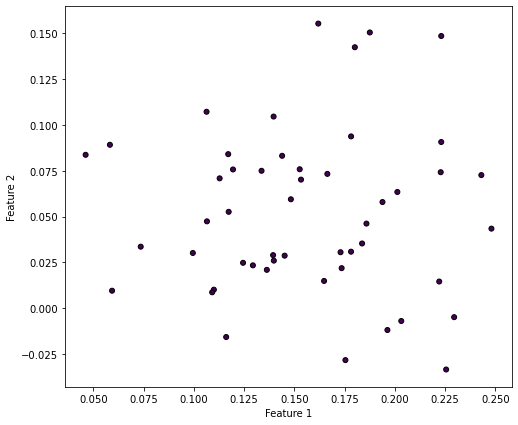

In [876]:
data1 = make_blobs(random_state=13,
                  n_samples=50, 
                  n_features=2, 
                  cluster_std=0.05,
                  center_box=(0,0.2),
                  centers=1,
                  return_centers=True
                  )
#data1
# print("X =", data1[0])
# print("Y =", data1[1])


plt.figure(figsize=(8, 7))
plt.scatter(data1[0][:,0], data1[0][:,1], marker='o', c=data1[1], s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

#### クラス内stdの異なるデータを結合

Text(0, 0.5, 'Feature 2')

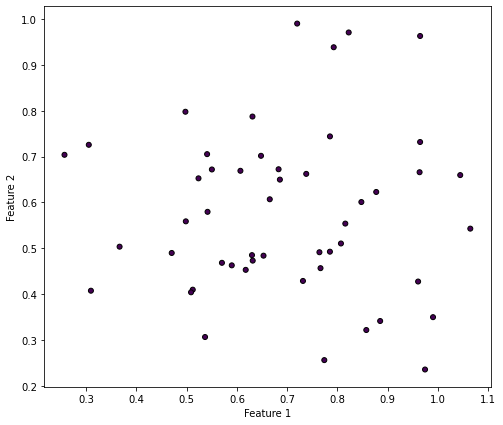

In [880]:
#生成
data2 = make_blobs(random_state=13,
                  n_samples=50, 
                  n_features=2, 
                  cluster_std=0.2,
                  center_box=(0.5,0.75),
                  centers=1,
                  return_centers=True
                  )
plt.figure(figsize=(8, 7))
plt.scatter(data2[0][:,0], data2[0][:,1], marker='o', c=data2[1], s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [881]:
#結合
label_u=[]
data2_label=[1]*50 #ラベルにしたい数*ユーザー数
data1_label=list(data1[1])
data=np.concatenate([data1[0],data2[0]])
label_u.extend(data1_label)
label_u.extend(data2_label)

Text(0, 0.5, 'Feature 2')

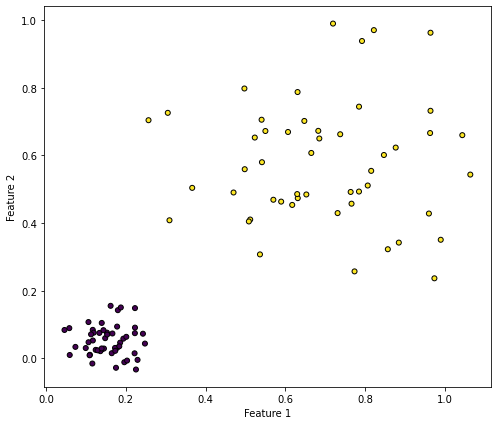

In [882]:
#プロット
plt.figure(figsize=(8, 7))
plt.scatter(data[:,0], data[:,1], marker='o', c=label_u, s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [826]:
#データフレームに変換
df_U=pd.DataFrame(data)
df_U_label=label_u
df_U_original=df_U.copy()
df_U_original

,0,1,2,3,4,...,55,56,57,58,59
0,-0.138074,0.065675,0.239502,0.197148,0.291127,...,-0.022902,0.114651,0.087048,0.105642,0.080074
1,0.331812,-0.059900,0.145693,0.241533,0.322033,...,-0.149679,0.143200,0.133168,0.024350,0.102120
2,0.226545,0.124757,0.218169,0.163881,0.096244,...,0.145814,0.151215,0.051608,-0.006873,0.036030
3,0.026777,0.184308,0.240980,0.289490,0.197874,...,0.077276,0.076094,0.262879,0.228838,-0.014478
4,0.205894,0.008783,0.298369,0.318072,0.383724,...,-0.150300,0.018750,0.115757,0.209987,0.126421
...,...,...,...,...,...,...,...,...,...,...,...
95,0.854669,0.604979,1.282125,0.818827,0.494046,...,0.229551,0.947863,0.955150,0.768223,0.833304
96,0.724756,0.639282,1.073936,1.108027,0.820041,...,0.768683,1.015910,0.874233,1.323015,0.493713
97,0.451057,0.146162,0.850689,1.362735,1.129113,...,0.271069,0.790260,0.674709,0.774041,1.204627
98,1.173983,0.889441,1.254422,1.230558,1.156159,...,0.680634,0.940508,1.187990,0.964832,0.900864


## df_Vを生成

Text(0, 0.5, 'Feature 2')

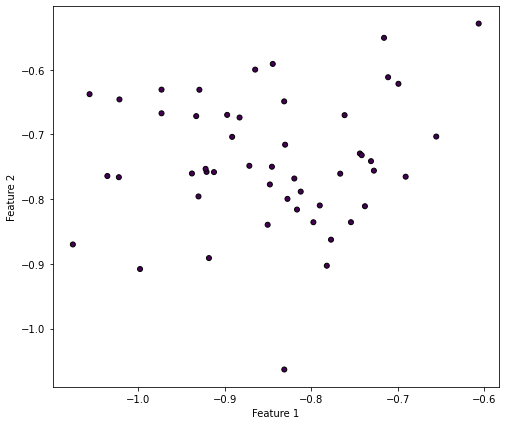

In [840]:
data1 = make_blobs(random_state=14,
                  n_samples=50, 
                  n_features=60, 
                  cluster_std=0.1,
                  center_box=(-1,-0.7),
                  centers=1,
                  return_centers=True
                  )
#data1
# print("X =", data1[0])
# print("Y =", data1[1])


plt.figure(figsize=(8, 7))
plt.scatter(data1[0][:,0], data1[0][:,1], marker='o', c=data1[1], s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

#### クラス内stdの異なるデータを結合

Text(0, 0.5, 'Feature 2')

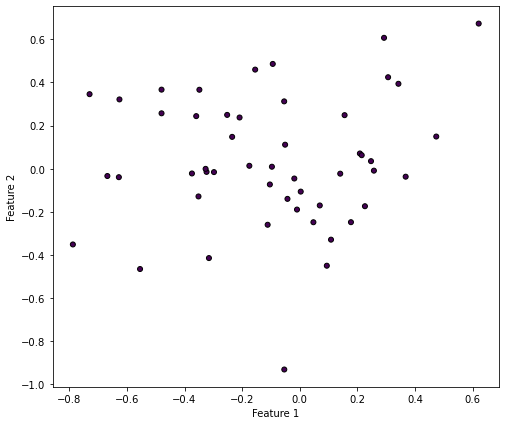

In [841]:
#生成
data2 = make_blobs(random_state=14,
                  n_samples=50, 
                  n_features=60, 
                  cluster_std=0.3,
                  center_box=(-0.2,0),
                  centers=1,
                  return_centers=True
                  )
plt.figure(figsize=(8, 7))
plt.scatter(data2[0][:,0], data2[0][:,1], marker='o', c=data2[1], s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [849]:
#結合
label_v=[]
data2_label=[2]*50 #ラベルにしたい数*ユーザー数
data1_label=list(data1[1])
data=np.concatenate([data1[0],data2[0]])
label_v.extend(data1_label)
label_v.extend(data2_label)

Text(0, 0.5, 'Feature 2')

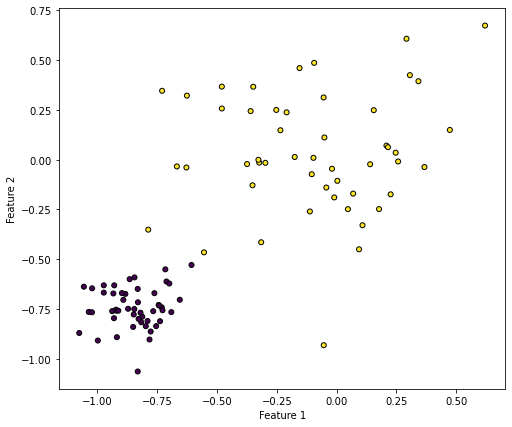

In [850]:
#プロット
plt.figure(figsize=(8, 7))
plt.scatter(data[:,0], data[:,1], marker='o', c=label_v, s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

#### ランダムに生成

Text(0, 0.5, 'Feature 2')

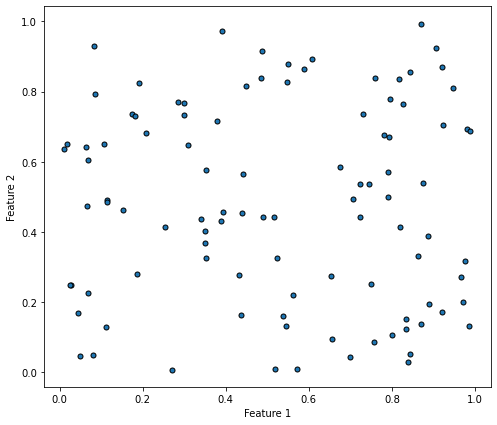

In [844]:
df_V = np.random.rand(100, 100)
plt.figure(figsize=(8, 7))
plt.scatter(df_V[:,0], df_V[:,1], marker='o', s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [794]:
df_V=pd.DataFrame(df_V)
df_V

,0,1,2,3,4,...,95,96,97,98,99
0,0.491529,0.629279,0.446803,0.075837,0.645685,...,0.065423,0.627562,0.199905,0.500108,0.538234
1,0.133422,0.956752,0.976849,0.048043,0.050593,...,0.114337,0.092249,0.600324,0.114698,0.383453
2,0.170785,0.279346,0.263780,0.783439,0.941532,...,0.760159,0.921075,0.801040,0.471537,0.670120
3,0.221805,0.792272,0.223590,0.246991,0.475233,...,0.636165,0.820037,0.280682,0.772423,0.980103
4,0.226672,0.234098,0.539817,0.728457,0.999579,...,0.036859,0.932482,0.424561,0.180354,0.289324
...,...,...,...,...,...,...,...,...,...,...,...
95,0.655043,0.955607,0.595142,0.058293,0.366592,...,0.205327,0.877630,0.639801,0.671680,0.833383
96,0.322139,0.481048,0.636871,0.171021,0.946025,...,0.358588,0.778025,0.887023,0.560682,0.882331
97,0.864776,0.588942,0.229078,0.950369,0.694705,...,0.384949,0.595585,0.030317,0.929509,0.055218
98,0.141045,0.173097,0.583344,0.217758,0.654407,...,0.600446,0.134353,0.944298,0.589222,0.961902


In [851]:
df_V=pd.DataFrame(data)
df_V_label=label
df_V_original=df_V.copy()
df_V_original

,0,1,2,3,4,...,55,56,57,58,59
0,-1.035974,-0.764264,-0.882521,-1.103294,-0.888437,...,-1.044929,-1.107506,-0.947682,-0.845520,-0.841323
1,-0.845638,-0.749915,-0.800473,-1.147083,-0.829408,...,-1.025915,-0.981963,-0.733289,-0.701967,-0.793425
2,-0.998168,-0.908045,-0.699028,-1.102496,-0.627209,...,-0.828144,-0.918617,-0.773170,-0.804466,-0.760596
3,-0.731017,-0.741290,-0.746441,-1.039078,-0.973407,...,-1.114245,-1.042208,-0.958069,-0.881110,-0.636982
4,-0.690930,-0.765299,-0.690505,-0.925838,-0.840304,...,-0.925270,-0.943645,-0.958511,-0.717979,-1.075102
...,...,...,...,...,...,...,...,...,...,...,...
95,0.620842,0.672915,0.488844,-0.031765,-0.703419,...,-0.753702,-0.489010,-0.528849,-0.343639,-0.452604
96,0.342329,0.393713,0.012759,-0.551863,-0.788006,...,-0.342300,-0.189572,0.101825,-0.055921,-0.405391
97,0.257288,-0.009136,0.371096,-0.239016,-0.426681,...,-0.298919,-0.346183,0.318771,0.106038,0.068602
98,-0.054109,0.312136,-0.206956,-0.503062,-0.038334,...,0.462782,-0.420877,-0.323206,-0.185208,-0.100750


## df_Rを生成

In [852]:
ar_U=df_U.values
ar_VT=df_V.values.T
df_R=pd.DataFrame(np.dot(ar_U,ar_VT))
df_R

,0,1,2,3,4,...,95,96,97,98,99
0,-4.846718,-4.941794,-4.730803,-4.958398,-4.760678,...,-0.648924,-1.405674,-0.019781,-0.747612,-0.308526
1,-4.582008,-4.632641,-4.475795,-4.421556,-4.305027,...,-0.158807,-0.847752,-0.143866,-0.672641,-1.143711
2,-4.485518,-4.580508,-4.416287,-4.586266,-4.311569,...,-0.516986,-0.603967,0.033092,-0.332289,-0.861910
3,-6.052071,-6.277724,-6.146993,-6.191628,-5.924251,...,-1.183919,-0.874031,-0.279085,-0.307884,-1.286089
4,-5.365071,-5.415771,-5.342862,-5.445526,-5.193008,...,-0.629084,-1.606532,-0.189742,-0.833501,-0.839146
...,...,...,...,...,...,...,...,...,...,...,...
95,-44.794326,-46.241322,-44.330741,-44.489608,-43.581446,...,-3.893050,-9.064077,-1.668542,-5.395442,-8.192471
96,-47.213386,-48.763710,-47.118355,-47.443622,-45.933712,...,-4.299894,-10.292230,-3.285349,-6.212411,-11.028976
97,-43.125018,-44.777488,-42.946539,-43.114300,-42.502222,...,-4.018578,-9.755766,-3.244256,-5.899279,-8.011224
98,-42.300080,-43.278933,-41.159193,-41.873159,-40.742412,...,-3.105168,-9.026781,-2.111258,-5.138961,-7.384036


Text(0, 0.5, 'Feature 2')

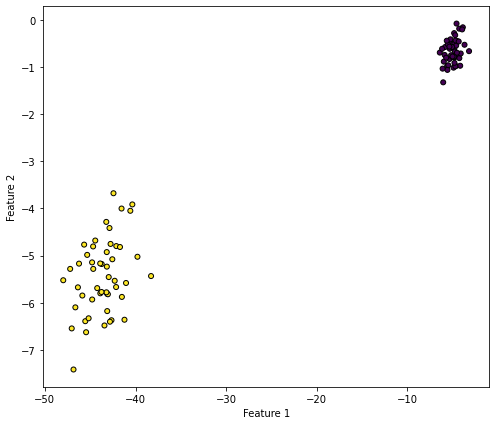

In [853]:
plt.figure(figsize=(8, 7))
plt.scatter(df_R[0],df_R[61], marker='o', c=label_u, s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

Text(0, 0.5, 'Feature 2')

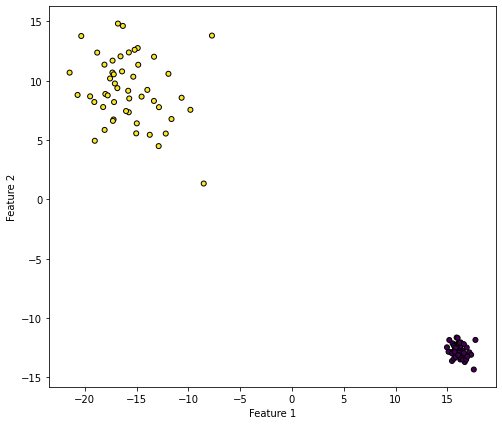

In [808]:
plt.figure(figsize=(8, 7))
plt.scatter(df_R.iloc[1],df_R.iloc[55], marker='o', c=label_v, s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [734]:
df_R.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_R_original.csv")

## 欠損を生成

In [645]:
def make_null(df,index,col_name): #データフレーム,発生させた乱数,列名
  df1 = df.drop(index) #欠損しないindexを集めたデータ
  df2 = df.iloc[index, :] #欠損するindexを集めたデータ
  df_c = df2[col_name] #欠損するindexを集めたデータの列名を指定
  df2[col_name] = np.nan #nanに置き換え
  result_df = pd.concat([df1,df2]).sort_index() #df1とdf2をくっつける
  return result_df, df_c #くっつけたデータと欠損した列名を返す

In [646]:
df_R_missing=pd.DataFrame()
np.random.seed(11) #乱数のシード値
for i in list(range(100)):#range(データフレームの列数)
    rand_mcar = np.sort(np.random.choice(df_R.index,70,replace=False)) #df1のインデックス番号からx個重複を許さず乱数発生
    dfR_result , mcar_correct = make_null(df_R, rand_mcar,i)
    dfR_result=list(dfR_result[i])
    df_R_missing.insert(i,i,dfR_result)

<ipython-input-645-7a8f389ec19c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col_name] = np.nan #nanに置き換え


In [647]:
df_R_missing

,0,1,2,3,4,...,95,96,97,98,99
0,NaN,NaN,7.617075,NaN,NaN,...,NaN,-5.250612,NaN,-10.046863,NaN
1,8.017775,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,8.051870,NaN,...,NaN,-4.086094,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,7.181286,...,NaN,NaN,-8.954274,-8.705326,-3.396249
4,7.808241,9.167386,NaN,7.838276,NaN,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,-9.243231,NaN,-7.859882,-7.494717,...,NaN,NaN,NaN,5.768969,7.376441
96,NaN,NaN,-10.643357,NaN,NaN,...,NaN,NaN,11.390465,NaN,NaN
97,NaN,-8.000688,NaN,-6.823898,NaN,...,4.147886,-0.751090,NaN,NaN,NaN
98,NaN,NaN,NaN,-6.300642,-5.416112,...,NaN,NaN,9.390687,NaN,NaN


In [648]:
df_R_missing.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_R__missing_original.csv")

# 分析

## 1回目のLFA

In [657]:
df_R_missing=df_R_missing.fillna(0) #欠損値を０で穴埋め
ar_R_missing=df_R_missing.values #データフレームをarray型に変換
mf = MatrixFactorization(ar_R_missing,k=60) #array型のデータ,行数,列数,LFA次元,
U,VT=mf.fit()
df_U1=pd.DataFrame(U)
df_V1=pd.DataFrame(VT.T)

100%|██████████| 200/200 [01:32<00:00,  2.15it/s]


In [659]:
df_U1

,0,1,2,3,4,...,55,56,57,58,59
0,-0.776194,0.437198,-0.103642,0.019767,0.634932,...,-0.154125,-0.115832,-0.274640,0.478683,0.204875
1,-0.748278,0.090051,0.653877,0.444950,0.499740,...,-0.162979,-0.035921,-0.254125,-0.179457,-0.593319
2,-0.542917,0.299612,0.057694,1.027113,0.425275,...,-0.512248,-0.120949,0.117253,0.054528,0.091408
3,-0.298467,0.000543,0.716676,0.383240,0.187477,...,-0.396539,-0.257223,-0.369554,0.306784,0.059522
4,-0.463366,0.205048,0.688357,0.217038,0.566007,...,-0.042161,0.447632,-0.285111,0.422990,-0.551051
...,...,...,...,...,...,...,...,...,...,...,...
95,1.955974,-0.083020,0.033183,-0.152089,0.366250,...,0.791632,0.431426,1.423838,0.140888,0.461703
96,0.879364,-1.048718,-0.643509,-0.322638,-0.586922,...,1.568625,0.393459,1.392581,0.191263,1.598570
97,0.691868,-0.350752,-0.780082,-0.059912,0.147426,...,0.163248,-0.332458,-0.030262,-0.495850,1.055778
98,1.334958,0.091285,0.082992,0.204670,-0.240532,...,0.611305,0.052040,1.473372,0.592867,0.542448


In [758]:
df_V1

,0,1,2,3,4,...,56,57,58,59,clust_label
0,-0.613753,0.072744,0.810574,0.049188,0.691440,...,0.006942,-0.723799,-0.022296,-0.523111,0
1,-0.947459,-0.039099,0.276624,0.242442,0.159543,...,0.374063,-0.231210,0.063485,-0.401356,0
2,-0.785065,0.103358,0.297365,0.229406,0.488954,...,-0.005365,-0.571408,0.058975,-0.606770,0
3,-0.432110,-0.151818,0.314840,0.042047,0.112829,...,-0.216942,-0.420093,0.510422,-0.690833,0
4,-0.494108,-0.153752,0.666719,0.228438,0.276342,...,-0.031885,-0.362749,0.457788,-0.139153,0
...,...,...,...,...,...,...,...,...,...,...,...
95,1.549235,0.206286,0.257430,-0.869653,0.433207,...,0.169263,0.957500,0.323821,1.381395,1
96,0.360736,0.329806,-0.030740,-0.044440,0.097199,...,0.933200,0.134247,-0.348241,-0.260691,1
97,1.834279,0.175760,-0.234187,0.275187,0.104996,...,0.755391,0.472070,0.171996,0.624459,1
98,0.441643,0.131161,-0.241934,-0.252010,-0.882369,...,0.212997,-0.327472,0.540880,0.141378,1


In [662]:
df_U1.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_U1.csv")

In [663]:
df_V1.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_V1.csv")

## 1回目時点での精度

In [664]:
ar_U1=df_U1.values
ar_V1=df_V1.values
R1_hat=pd.DataFrame(np.dot(ar_U1,ar_V1.T))
R1_hat

,0,1,2,3,4,...,95,96,97,98,99
0,7.242612,8.119434,7.615018,7.248915,6.334246,...,-9.678718,-5.247602,-7.073432,-10.043292,-3.551545
1,8.017008,7.183819,6.404348,6.721097,6.930881,...,-9.612368,-4.492227,-8.907176,-8.955768,-1.573659
2,7.538474,9.139425,7.950020,8.051443,7.765564,...,-9.273221,-4.085088,-8.722208,-8.613325,-4.547890
3,7.531514,7.595085,7.954641,7.280553,7.179712,...,-7.700490,-4.179731,-8.955260,-8.704484,-3.395095
4,7.806798,9.167207,6.955403,7.833596,7.550203,...,-10.228818,-3.029995,-7.372088,-9.837056,-1.704836
...,...,...,...,...,...,...,...,...,...,...,...
95,-6.579499,-9.237934,-9.300372,-7.858871,-7.492844,...,13.119819,4.847022,10.618578,5.772915,7.366789
96,-9.348512,-8.777247,-10.637869,-8.850583,-7.773751,...,9.837843,3.169099,11.391214,7.716927,5.416124
97,-6.300896,-7.998272,-7.063687,-6.821501,-6.474297,...,4.147452,-0.745659,7.454565,5.189146,1.618398
98,-4.834509,-5.780780,-5.763744,-6.298468,-5.414670,...,6.625087,2.213472,9.389324,3.839519,4.473442


In [665]:
#元の行列の値とR_hatの誤差を調べる
def RMSE0(ar_original,ar_R_hat):#元の欠損する前の行列(array型),欠損した行列,潜在因子行列をかけた行列
    total=0
    x=ar_original.shape[0]
    y=ar_original.shape[1]
    count=x*y
    X=list(range(ar_original.shape[0]))
    Y=list(range(ar_original.shape[1]))
    for i in X:
        for j in Y:    
            total+=(ar_original[i,j]-ar_R_hat[i,j])**2
    score=np.sqrt(total/count)
    return score,count

In [666]:
ar_R=df_R.values
ar_R1_hat=R1_hat.values
score,count=RMSE0(ar_R,ar_R1_hat)
print(score)
print(count)

1.637954981625289
10000


## RでDPクラスタリング

## 提案手法はcolabで実装

## DPクラスタリングの結果をono-hotエンコーディングする

In [667]:
df_U1_re=pd.read_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_U1_clustering_result.csv")
df_U1_re

,Unnamed: 0,X0,X1,X2,X3,...,X56,X57,X58,X59,clust_label
0,1,-0.776194,0.437198,-0.103642,0.019767,...,-0.115832,-0.274640,0.478683,0.204875,0
1,2,-0.748278,0.090051,0.653877,0.444950,...,-0.035921,-0.254125,-0.179457,-0.593319,0
2,3,-0.542917,0.299612,0.057694,1.027113,...,-0.120949,0.117253,0.054528,0.091408,0
3,4,-0.298467,0.000543,0.716676,0.383240,...,-0.257223,-0.369554,0.306784,0.059522,0
4,5,-0.463366,0.205048,0.688357,0.217038,...,0.447632,-0.285111,0.422990,-0.551051,0
...,...,...,...,...,...,...,...,...,...,...,...
95,96,1.955974,-0.083020,0.033183,-0.152089,...,0.431426,1.423838,0.140888,0.461703,1
96,97,0.879364,-1.048718,-0.643509,-0.322638,...,0.393459,1.392581,0.191263,1.598570,1
97,98,0.691868,-0.350752,-0.780082,-0.059912,...,-0.332458,-0.030262,-0.495850,1.055778,1
98,99,1.334958,0.091285,0.082992,0.204670,...,0.052040,1.473372,0.592867,0.542448,1


In [698]:
label_U1=df_U1_re["clust_label"]
label_U1_onehot=np_utils.to_categorical(label_U1)
#label_U1_onehot=np.tile(label_U1_onehot,50)
label_U1_onehot

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [670]:
df_V1_re=pd.read_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_V1_clustering_result.csv")
df_V1_re

,Unnamed: 0,X0,X1,X2,X3,...,X56,X57,X58,X59,clust_label
0,1,-0.613753,0.072744,0.810574,0.049188,...,0.006942,-0.723799,-0.022296,-0.523111,0
1,2,-0.947459,-0.039099,0.276624,0.242442,...,0.374063,-0.231210,0.063485,-0.401356,0
2,3,-0.785065,0.103358,0.297365,0.229406,...,-0.005365,-0.571408,0.058975,-0.606770,0
3,4,-0.432110,-0.151818,0.314840,0.042047,...,-0.216942,-0.420093,0.510422,-0.690833,0
4,5,-0.494108,-0.153752,0.666719,0.228438,...,-0.031885,-0.362749,0.457788,-0.139153,0
...,...,...,...,...,...,...,...,...,...,...,...
95,96,1.549235,0.206286,0.257430,-0.869653,...,0.169263,0.957500,0.323821,1.381395,1
96,97,0.360736,0.329806,-0.030740,-0.044440,...,0.933200,0.134247,-0.348241,-0.260691,1
97,98,1.834279,0.175760,-0.234187,0.275187,...,0.755391,0.472070,0.171996,0.624459,1
98,99,0.441643,0.131161,-0.241934,-0.252010,...,0.212997,-0.327472,0.540880,0.141378,1


In [699]:
label_V1=df_V1_re["clust_label"]
label_V1_onehot=np_utils.to_categorical(label_V1)
label_V1_onehot=label_V1_onehot.T
#label_V1_onehot=np.tile(label_V1_onehot,(50,1))
label_V1_onehot

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]], dtype=float32)

## ユーザーのクラスター内標準偏差を計算

### クラスが0のデータのクラスター内標準偏差

In [681]:
df_U1["clust_label"]=df_U1_re["clust_label"]
df_U1.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_U1_DCALF-A.csv")
df_U1_0=df_U1[df_U1["clust_label"]==0]
df_U1_0=df_U1_0.iloc[:,:60]
df_U1_0_std=df_U1_0.describe().loc['std'].mean()
df_U1_0_std

0.26340757444235824

In [682]:
df_U1_0

,0,1,2,3,4,...,55,56,57,58,59
0,-0.776194,0.437198,-0.103642,0.019767,0.634932,...,-0.154125,-0.115832,-0.274640,0.478683,0.204875
1,-0.748278,0.090051,0.653877,0.444950,0.499740,...,-0.162979,-0.035921,-0.254125,-0.179457,-0.593319
2,-0.542917,0.299612,0.057694,1.027113,0.425275,...,-0.512248,-0.120949,0.117253,0.054528,0.091408
3,-0.298467,0.000543,0.716676,0.383240,0.187477,...,-0.396539,-0.257223,-0.369554,0.306784,0.059522
4,-0.463366,0.205048,0.688357,0.217038,0.566007,...,-0.042161,0.447632,-0.285111,0.422990,-0.551051
...,...,...,...,...,...,...,...,...,...,...,...
45,-0.280529,0.181858,0.071449,0.685698,1.315355,...,-0.108963,-0.357363,-0.632909,-0.245817,-0.143709
46,-0.818033,0.019658,0.105755,0.682294,-0.143402,...,-0.473406,0.015697,-0.255666,-0.295564,-0.034832
47,-0.645705,0.068352,0.194598,0.260427,0.256768,...,-0.786079,0.314091,-0.143127,0.278099,-0.605803
48,-0.988645,0.273853,0.608084,0.589058,0.529567,...,-0.352396,0.021292,-0.230480,0.380908,-0.148832


### クラスが1のデータのクラスター内標準偏差

In [683]:
df_U1["clust_label"]=df_U1_re["clust_label"]
df_U1_1=df_U1[df_U1["clust_label"]==1]
df_U1_1=df_U1_1.iloc[:,:60]
df_U1_1_std=df_U1_1.describe().loc['std'].mean()
df_U1_1_std

0.4117540102127217

### リストに格納

In [684]:
user_clust_std=list([df_U1_0_std,df_U1_1_std])
user_clust_std

[0.26340757444235824, 0.4117540102127217]

## サービスのクラスター内標準偏差を計算

### クラスが0のデータのクラスター内標準偏差

In [695]:
df_V1["clust_label"]=df_V1_re["clust_label"]
df_V1.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_V1_DCALF-A.csv")
df_V1_0=df_V1[df_V1["clust_label"]==0]
df_V1_0=df_V1_0.iloc[:,:60]
df_V1_0_std=df_V1_0.describe().loc['std'].mean()
df_V1_0_std

0.2696876944364737

### クラスが1のデータのクラスター内標準偏差

In [696]:
df_V1["clust_label"]=df_V1_re["clust_label"]
df_V1_1=df_V1[df_V1["clust_label"]==1]
df_V1_1=df_V1_1.iloc[:,:60]
df_V1_1_std=df_V1_1.describe().loc['std'].mean()
df_V1_1_std

0.433730709346863

### リストに格納


In [687]:
service_clust_std=list([df_V1_0_std,df_V1_1_std])
service_clust_std

[0.2696876944364737, 0.433730709346863]

## 2回目のLFA

#### 重み変えない+ユーザのみクラスター

In [413]:
C=label_U1_onehot
df_R_missing=df_R_missing.fillna(0) #欠損値を０で穴埋め
ar_R_missing=df_R_missing.values #データフレームをarray型に変換
mf = MatrixFactorization_1_1(ar_R_missing,C,k=60)
U,VT,S=mf.fit()
df_U2=pd.DataFrame(U)
df_V2=pd.DataFrame(VT)
df_S=pd.DataFrame(S)

In [414]:
ar_U2=df_U2.values
ar_V2=df_V2.values
R2_hat=pd.DataFrame(np.dot(ar_U2,ar_V2))
R2_hat

,0,1,2,3,4,...,95,96,97,98,99
0,-14.692683,-13.539463,-15.572225,-13.722075,-15.508433,...,-16.034260,-16.462524,-16.103778,-20.408629,-15.453587
1,-16.818712,-15.841313,-14.982156,-13.012394,-15.830160,...,-15.963930,-16.554935,-16.371202,-20.839706,-15.757262
2,-15.450784,-15.469156,-14.667788,-14.462866,-15.526465,...,-16.044704,-16.721829,-16.783376,-20.540367,-15.667000
3,-14.902487,-14.284886,-13.185726,-12.800385,-16.169453,...,-15.681756,-15.687509,-15.861346,-19.073019,-14.724682
4,-16.258434,-16.877544,-14.438515,-13.847516,-15.921124,...,-15.327359,-16.225810,-15.522840,-19.468666,-14.384923
...,...,...,...,...,...,...,...,...,...,...,...
95,14.379344,15.582511,14.186328,17.167781,16.378603,...,16.749729,15.699800,14.710722,21.009145,12.131640
96,17.247017,18.984742,16.774913,17.327582,18.680786,...,18.702389,18.330952,17.867770,23.797754,16.482714
97,12.822143,14.632304,12.259157,12.222605,14.085973,...,14.587556,13.341292,13.153754,17.552094,12.010617
98,10.063853,10.410975,9.694236,10.412029,12.181831,...,11.970369,12.078608,11.007558,15.165318,10.777778


In [415]:
ar_R=df_R.values
ar_R2_hat=R2_hat.values
score,count=RMSE0(ar_R,ar_R2_hat)
print(score)
print(count)

1.1617292912373638
10000


#### 重み変えない＋両方クラスター


In [762]:
C=label_U1_onehot
D=label_V1_onehot
df_R_missing=df_R_missing.fillna(0) #欠損値を０で穴埋め
ar_R_missing=df_R_missing.values #データフレームをarray型に変換
mf = MatrixFactorization_1(ar_R_missing,C,D,k=60)
U,VT,S,T=mf.fit()
df_U2=pd.DataFrame(U)
df_V2=pd.DataFrame(VT)
df_S=pd.DataFrame(S)
df_T=pd.DataFrame(T)

100%|██████████| 200/200 [15:16<00:00,  4.58s/it]


In [521]:
ar_U2=df_U2.values
ar_V2=df_V2.values
R2_hat=pd.DataFrame(np.dot(ar_U2,ar_V2))
R2_hat

,0,1,2,3,4,...,95,96,97,98,99
0,13.209313,14.350829,15.712956,12.828501,13.037978,...,-15.425024,-11.748479,-15.112462,-18.461019,-10.571874
1,16.174675,16.311019,15.432872,15.163114,14.297083,...,-17.448137,-9.246392,-17.038566,-17.546599,-8.396742
2,15.466702,16.601617,14.372065,15.930892,14.604075,...,-14.795973,-10.626841,-18.283454,-17.874238,-10.791228
3,14.649395,15.186533,15.632885,14.281221,14.702421,...,-16.110208,-8.074952,-16.970117,-16.642615,-9.184879
4,15.671044,16.994369,14.531712,15.633889,14.106396,...,-16.326773,-8.178251,-16.216639,-16.074504,-7.456076
...,...,...,...,...,...,...,...,...,...,...,...
95,-16.037189,-18.267898,-14.945266,-16.871021,-16.528753,...,15.531421,8.088826,19.243607,11.666255,13.788751
96,-17.608155,-18.422054,-23.508432,-17.760221,-17.515619,...,14.891263,8.449625,18.302277,16.495377,6.066502
97,-14.163821,-15.202073,-12.932579,-14.078477,-12.666468,...,9.785029,2.980921,19.045565,13.976676,9.403152
98,-11.587867,-12.262551,-12.254591,-12.335067,-11.415771,...,12.937690,6.297240,16.767976,10.952931,5.175285


### 評価(重みを変えない)

In [522]:
ar_R=df_R.values
ar_R2_hat=R2_hat.values
score,count=RMSE0(ar_R,ar_R2_hat)
print(score)
print(count)

2.3575900686008024
10000


## 2回目のLFA(重みを変える)

#### 重み変える+ユーザのみクラスター

In [409]:
C=label_U1_onehot
df_R_missing=df_R_missing.fillna(0) #欠損値を０で穴埋め
ar_R_missing=df_R_missing.values #データフレームをarray型に変換
mf = MatrixFactorization_2_1(ar_R_missing,C,label_U1,user_clust_std,k=60)
U,VT,S,=mf.fit()
df_U2=pd.DataFrame(U)
df_V2=pd.DataFrame(VT)
df_S=pd.DataFrame(S)

In [410]:
ar_U2=df_U2.values
ar_V2=df_V2.values
R2_hat=pd.DataFrame(np.dot(ar_U2,ar_V2))
R2_hat

,0,1,2,3,4,...,95,96,97,98,99
0,-14.569186,-14.025948,-15.585619,-13.749671,-15.161700,...,-15.974013,-16.483946,-16.692456,-20.406023,-15.605347
1,-16.804734,-15.928917,-15.928938,-13.558390,-15.531444,...,-15.699348,-16.533076,-16.272359,-20.814015,-15.222309
2,-15.463439,-15.676906,-15.560163,-14.460122,-15.784122,...,-15.755964,-16.724485,-15.662397,-20.180644,-15.037113
3,-15.283372,-15.217728,-14.441701,-12.882614,-16.149807,...,-15.188465,-16.291367,-15.866287,-19.054821,-14.733751
4,-16.271508,-16.838518,-14.991156,-13.847290,-15.905756,...,-15.646907,-15.837909,-15.310450,-19.550649,-14.395735
...,...,...,...,...,...,...,...,...,...,...,...
95,14.464983,15.563465,15.088514,17.175301,16.368161,...,15.783564,15.778407,14.833232,21.017125,12.124198
96,18.104513,20.121484,16.771525,16.312854,19.058105,...,18.901537,19.023149,17.861908,22.979491,15.861266
97,13.723754,14.641874,12.275423,12.216444,14.673727,...,14.586429,13.331893,12.625985,18.184415,13.134001
98,10.504441,11.831333,11.450983,10.397956,12.184886,...,12.830101,11.626317,11.011851,14.755041,10.777583


In [411]:
ar_R=df_R.values
ar_R2_hat=R2_hat.values
score,count=RMSE0(ar_R,ar_R2_hat)
print(score)
print(count)

1.138861620435225
10000


#### 重み変える+両方クラスター

In [720]:
C=label_U1_onehot
D=label_V1_onehot
df_R_missing=df_R_missing.fillna(0) #欠損値を０で穴埋め
ar_R_missing=df_R_missing.values #データフレームをarray型に変換
mf = MatrixFactorization_2(ar_R_missing,C,D,label_U1,label_V1,user_clust_std,service_clust_std,k=60)
U,VT,S,T=mf.fit()
df_U2=pd.DataFrame(U)
df_V2=pd.DataFrame(VT)
df_S=pd.DataFrame(S)
df_T=pd.DataFrame(T)

100%|██████████| 200/200 [15:51<00:00,  4.76s/it]


In [721]:
ar_U2=df_U2.values
ar_V2=df_V2.values
R2_hat=pd.DataFrame(np.dot(ar_U2,ar_V2))
R2_hat

,0,1,2,3,4,...,95,96,97,98,99
0,7.384689,8.531716,7.597865,7.239293,7.354974,...,-7.532574,-5.230928,-7.228852,-10.012860,-1.300274
1,7.990167,9.004291,7.474818,8.015800,7.289856,...,-11.156326,-4.250824,-8.982704,-8.708783,-2.841577
2,8.795168,9.583510,7.917063,8.026133,7.629556,...,-9.347468,-4.077613,-5.603481,-8.259534,-2.013390
3,7.405235,8.691485,6.591881,7.671428,7.139384,...,-10.257076,-2.131613,-8.924493,-8.719662,-3.349510
4,7.813507,9.134889,6.857807,7.850143,7.781062,...,-8.648037,-3.036859,-6.562141,-7.832352,-2.581929
...,...,...,...,...,...,...,...,...,...,...,...
95,-7.209102,-9.195309,-7.342867,-7.835790,-7.464158,...,10.442867,4.327248,9.758855,5.811724,7.297501
96,-10.325288,-8.584771,-10.612208,-8.706358,-7.245677,...,11.434750,4.293112,11.399392,5.116097,5.953013
97,-6.632690,-7.993579,-6.230598,-6.830718,-6.583414,...,4.148905,-0.673673,7.949053,5.780250,1.646966
98,-7.541918,-6.277103,-5.621060,-6.272005,-5.399893,...,7.075459,3.971039,9.369282,4.790458,2.342849


### 評価(重みを変える)

In [722]:
ar_R=df_R.values
ar_R2_hat=R2_hat.values
score,count=RMSE0(ar_R,ar_R2_hat)
print(score)
print(count)

1.6460680852466396
10000


Text(0, 0.5, 'Feature 2')

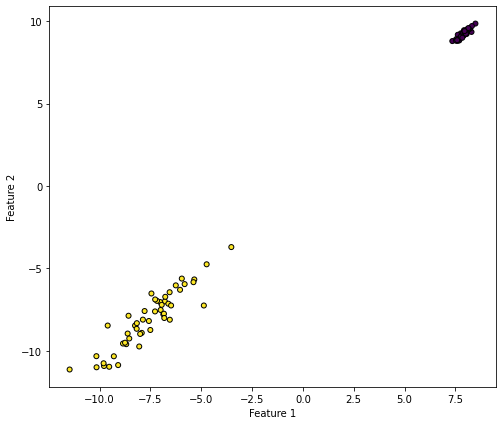

In [716]:
plt.figure(figsize=(8, 7))
plt.scatter(df_R[0], df_R[1], marker='o', c=df_U1_re["clust_label"], s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

Text(0, 0.5, 'Feature 2')

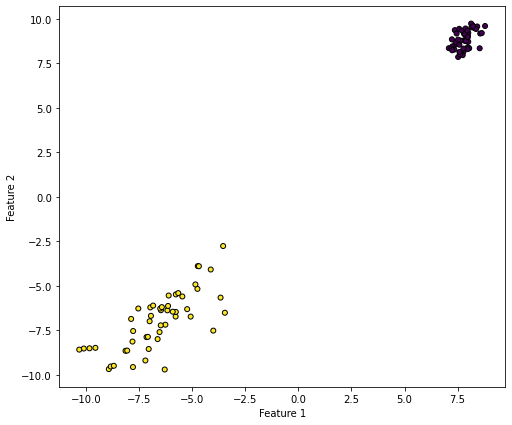

In [723]:
plt.figure(figsize=(8, 7))
plt.scatter(R2_hat[0], R2_hat[1], marker='o', c=df_U1_re["clust_label"], s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

Text(0, 0.5, 'Feature 2')

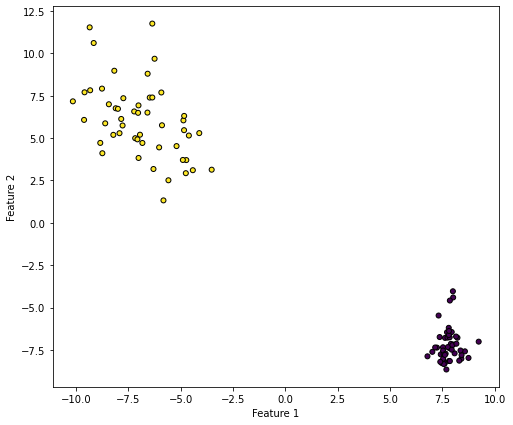

In [861]:
plt.figure(figsize=(8, 7))
plt.scatter(R1_hat[0], R1_hat[61], marker='o', c=df_U1_re["clust_label"], s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")